# 強化学習 3日目 @ Summer School 数理物理 2021
## Q learning
- Q関数の初期化の影響調査
***
Tetsuro Morimura, 2021

# 準備
### Import required Python packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# 環境の設定
### MDPクラスの定義
- Environment classのスーパークラス

In [2]:
class MDP:
    def __init__(self, state_set, action_set, init_prob, trans_prob, reward_fun):
        self.state_set   = state_set
        self.action_set  = action_set
        self.nstate      = len(state_set)
        self.naction     = len(action_set)
        self._init_prob  = init_prob
        self._trans_prob = trans_prob   #d1:state, d2:action, d3:next_state
        self._reward_fun = reward_fun   #d1:state, d2:action
        self._state      = None
        self._action     = None
        self._reward     = None
    def set_state(self, state):
        self._state  = state
    def set_action(self, action):
        self._action = action
    def get_trans_matrix(self, state):
        return np.array(self._trans_prob[state])
    def get_reward_vec(self, state):
        return np.array(self._reward_fun[state])
    def get_state(self):
        return self._state
    def get_action(self):
        return self._action
    def get_reward(self):
        return self._reward_fun[self._state][self._action]
    def get_value_fun(self, gamma, policy): 
        r_s  = np.zeros(self.nstate)
        P_ss = np.zeros((self.nstate,self.nstate))
        if np.shape(policy) == (self.nstate,): # deterministic policy
            for s in range(self.nstate):
                r_s[s]  = self.get_reward_vec(s) [policy[s]]
                P_ss[s] = self.get_trans_matrix(s)[policy[s]]
        else: # stochastic policy
            policy = np.array(policy)
            for s in range(self.nstate):
                r_s[s]  = np.inner(policy[s], self.get_reward_vec(s))
                P_ss[s] = np.inner(policy[s], self.get_trans_matrix(s).T)
        value_fun = np.linalg.solve(np.eye(self.nstate)-gamma*P_ss, r_s)  # solve Ax = b 
        return value_fun
    def get_q_value_fun(self, gamma, policy):
        value_fun   = self.get_value_fun(gamma, policy)
        q_value_fun = np.zeros((self.nstate,self.naction))
        for s in range(self.nstate):
            r_vector       = self.get_reward_vec(s) 
            P_matrix       = self.get_trans_matrix(s) # d1:action, d2:next_state
            q_value_fun[s] = r_vector + gamma * np.inner(value_fun, P_matrix)
        return q_value_fun
    def reset(self):
        init_state  = np.random.choice(self.state_set, p=self._init_prob)
        self._state  = init_state
        self._action = None
        return init_state
    def step(self, action=None):
        state = self.get_state()
        if action is None:
            action = self.get_action()
        else:
            self.set_action(action)
        if state is None or action is None:
            raise Exception("'state' or/and 'action' is not set!")
        next_state   = np.random.choice(self.state_set, p=self._trans_prob[state][action])
        reward       = self.get_reward()
        self._state  = next_state
        self._reward = reward
        self._action = None
        return next_state, reward

### Environmentクラスの定義
- MDPクラスを継承
- 環境が未知であることを保証するため、一部のメソッドを遮蔽

In [3]:
class Environment(MDP):
    def set_state(self):
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_trans_matrix(self):
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_reward_vec(self):
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_value_fun(self): 
        raise Exception("This method is not available!") #自由に状態をリセットできないので
    def get_q_value_fun(self): 
        raise Exception("This method is not available!") #自由に状態をリセットできないので

### 環境インスタンス (env) の生成
 - 3状態2行動MDPの「損して得とれ課題」

In [4]:
state_set  = [0,1,2]
action_set = [0,1]
init_prob  = [0.6, 0.3, 0.1]
trans_prob = np.zeros(len(state_set)*len(action_set)*len(state_set)).reshape(len(state_set), len(action_set), len(state_set)) #d1:state, d2:action, d3:next state
trans_prob[0][0] = [1,   0,   0]
trans_prob[0][1] = [0.5, 0.5, 0]
trans_prob[1][0] = [1,   0,   0] 
trans_prob[1][1] = [0,   0.5, 0.5]
trans_prob[2][0] = [0,   1,   0]
trans_prob[2][1] = [1,   0,   0]
reward_fun       = [[1.0, -1.0],
                    [1.0, -1.0],
                    [1.0, 12.0],]   #d1:state, d2:action

mdp = MDP(state_set, action_set, init_prob, trans_prob, reward_fun) # 環境未知の時、agentからのアクセスNG
env = Environment(state_set, action_set, init_prob, trans_prob, reward_fun)
del state_set, action_set, init_prob, trans_prob, reward_fun

### 動作確認
- 状態集合，行動集合の確認

In [5]:
print('state set: ',  env.state_set)
print('action set:', env.action_set)

state set:  [0, 1, 2]
action set: [0, 1]


- 環境を初期化して、初期観測を確認

In [6]:
init_state = env.reset() ## 環境の初期化
print('initial state:', init_state)

initial state: 1


- エピソード生成（行動は乱択）

In [7]:
init_state  = env.reset() 

max_timestep = 10
timestep     = 0

print('initial state:', init_state)

while timestep < max_timestep:
    action             = np.random.choice(env.action_set) ## ランダムな行動選択
    next_state, reward = env.step(action) ## 行動を環境に入力して、次状態と報酬を受け取る
    # print
    print('----------- time step {} --------'.format(timestep))
    print('action:', action,
          'next state:', next_state,
          'reward:', reward)
    # update timespte
    timestep          +=1
    

initial state: 1
----------- time step 0 --------
action: 0 next state: 0 reward: 1.0
----------- time step 1 --------
action: 1 next state: 0 reward: -1.0
----------- time step 2 --------
action: 1 next state: 0 reward: -1.0
----------- time step 3 --------
action: 1 next state: 1 reward: -1.0
----------- time step 4 --------
action: 1 next state: 2 reward: -1.0
----------- time step 5 --------
action: 0 next state: 1 reward: 1.0
----------- time step 6 --------
action: 0 next state: 0 reward: 1.0
----------- time step 7 --------
action: 1 next state: 1 reward: -1.0
----------- time step 8 --------
action: 0 next state: 0 reward: 1.0
----------- time step 9 --------
action: 1 next state: 0 reward: -1.0


- 価値関数の計算
 - mdpクラス (<- agentは使用禁止)を使用
 - envクラスでは計算できない

In [8]:
## e-greedy policy
# param
gamma = 0.9
eps   = 0.1
# comp
p_greedy     = 1 - eps/2
p_nongreedy  = eps/2
policy1    = [[p_greedy,p_nongreedy], [p_greedy,p_nongreedy], [p_nongreedy,p_greedy]]
policy2    = [[p_greedy,p_nongreedy], [p_nongreedy,p_greedy], [p_nongreedy,p_greedy]]
policy3    = [[p_nongreedy,p_greedy], [p_nongreedy,p_greedy], [p_nongreedy,p_greedy]]
policy_opt = [[0., 1.], [0., 1.], [0., 1.]]
# print
print('V of policy1: ', mdp.get_value_fun(gamma, policy1))
print('V of policy2: ', mdp.get_value_fun(gamma, policy2))
print('V of policy3: ', mdp.get_value_fun(gamma, policy3))
print('Optimal V:    ', mdp.get_value_fun(gamma, policy_opt))
print('')
print('Q of policy1: ', mdp.get_q_value_fun(gamma, policy1))
print('Q of policy2: ', mdp.get_q_value_fun(gamma, policy2))
print('Q of policy3: ', mdp.get_q_value_fun(gamma, policy3))
print('Optimal Q:    ', mdp.get_q_value_fun(gamma, policy_opt))

V of policy1:  [ 9.05343643  9.29093166 19.60878007]
V of policy2:  [10.0416769  14.671352   20.69584459]
V of policy3:  [10.39839549 14.93603186 21.01274958]
Optimal V:     [11.89189189 16.75675676 22.7027027 ]

Q of policy1:  [[ 9.14809278  7.25496564]
 [ 9.14809278 12.00487028]
 [ 9.36183849 20.14809278]]
Q of policy2:  [[10.03750921 10.12086301]
 [10.03750921 14.91523847]
 [14.2042168  21.03750921]]
Q of policy3:  [[10.35855594 10.40049231]
 [10.35855594 15.17695165]
 [14.44242868 21.35855594]]
Optimal Q:     [[11.7027027  11.89189189]
 [11.7027027  16.75675676]
 [16.08108108 22.7027027 ]]


# エージェントの設定

### RLエージェントクラスの定義
- アブストラクトクラス

In [9]:
## Abstract RL agent class 
class Agent():
    def __init__(self, state_space, action_space, gamma=0.9):
        self.state_space  = state_space
        self.action_space = action_space
        self.gamma        = gamma
        self.experiences  = []
        self.timestep     = 0

    def reset(self):
        # エージェントの初期化
        raise NotImplementedError("class is abstract.") 

    def add_experience(self, state, action, reward, next_state):
        # 経験データの追加
        raise NotImplementedError("class is abstract.") 

    def policy(self, state):
        # 行動選択
        raise NotImplementedError("class is abstract.")

    def learning(self):
        # 学習
        raise NotImplementedError("class is abstract.")

### Q学習エージェントクラスの実装
- Agentクラスを継承
- Q関数: Table形式
- 方策: Epsilon-greedy

In [10]:
## Q-learning agent (tabular version with epsilon-greedy policy)
class TabularQlearning(Agent):
    def __init__(self, state_space, action_space, gamma=0.9, epsilon=[100., 100.],alpha=[200., 200.]):
        super().__init__(state_space, action_space, gamma)
        self.nstate  = len(state_space) 
        self.naction = len(action_space)
        self.q_fun   = np.random.randn(self.nstate, self.naction) / 1000
        self.epsilon = epsilon # hyper-param for e-greedy
        self.alpha   = alpha   # hyper-hparam for learning rate

    def reset(self, q_bias=0.):
        self.timestep    = 0
        self.experiences = []
        self.q_fun       = np.random.randn(self.nstate, self.naction) / 1000 + q_bias


    def add_experience(self, state, action, reward, next_state):
        self.experiences = [state, action, reward, next_state]


    def policy(self, state): #Epsilon-Greedy Agent Policy
        # epsilonの設定
        if isinstance(self.epsilon, list) != True:
            epsilon = self.epsilon
        else:
            epsilon = self.epsilon[0] / (self.timestep + self.epsilon[1])
        # 行動選択
        if epsilon <= np.random.uniform():
            action = np.argmax(self.q_fun[state])
        else:
            action = np.random.choice(self.naction)
        return action


    def learning_rate(self):
        if isinstance(self.alpha, list) != True:
            learning_rate = self.alpha
        else:
            learning_rate = self.alpha[0] / (self.timestep + self.alpha[1])
        return learning_rate


    def learning(self):
        state, action, reward, next_state = self.experiences
        
        td_error = reward + self.gamma * np.max(self.q_fun[next_state]) - self.q_fun[state][action]
        self.q_fun[state][action] += self.learning_rate() * td_error 

### SARSAエージェントクラスの実装
- Agentクラスを継承
- Q関数: Table形式
- 方策: Epsilon-greedy

In [11]:
## SARSA-learning agent (tabular version with epsilon-greedy policy)
class TabularSARSA(Agent):
    def __init__(self, state_space, action_space, gamma=0.9, epsilon=[100., 100.],alpha=[200., 200.]):
        super().__init__(state_space, action_space, gamma)
        self.nstate  = len(state_space) 
        self.naction = len(action_space)
        self.q_fun   = np.random.randn(self.nstate, self.naction) / 1000
        self.epsilon = epsilon # hyper-param for e-greedy
        self.alpha   = alpha   # hyper-hparam for learning rate

    def reset(self, q_bias=0.):
        self.timestep    = 0
        self.experiences = []
        self.q_fun       = np.random.randn(self.nstate, self.naction) / 1000 + q_bias


    def add_experience(self, state, action, reward, next_state):
        self.experiences.append([state, action, reward, next_state])
        if len(self.experiences) > 2: 
            del self.experiences[0]  #delete old experiences

    def policy(self, state): #Epsilon-Greedy Agent Policy
        # epsilonの設定
        if isinstance(self.epsilon, list) != True:
            epsilon = self.epsilon
        else:
            epsilon = self.epsilon[0] / (self.timestep + self.epsilon[1])
        # 行動選択
        if epsilon <= np.random.uniform():
            action = np.argmax(self.q_fun[state])
        else:
            action = np.random.choice(self.naction)
        return action


    def learning_rate(self):
        if isinstance(self.alpha, list) != True:
            learning_rate = self.alpha
        else:
            learning_rate = self.alpha[0] / (self.timestep + self.alpha[1])
        return learning_rate


    def learning(self):
        if len(self.experiences) == 2:
            state, action, reward, _      = self.experiences[0]
            next_state, next_action, _, _ = self.experiences[1]
        
            td_error = reward + self.gamma * self.q_fun[next_state][next_action] - self.q_fun[state][action]
            self.q_fun[state][action] += self.learning_rate() * td_error 

# 実験

### 実験条件の設定

In [12]:
## Set parameter of experiment
n_experiment = 30   # num of experiments
n_timestep   = 2100  # length of episode 
gamma        = 0.9   # discounting rate
q_val_bias   = 100.  # bias for optimisitic initilization of Q-value

### 学習

- RLエージェントインスタンスを生成

In [13]:
## Generate agent
agent = TabularQlearning(env.state_set, env.action_set)
agent.gamma   = gamma      # discounting rate
agent.alpha   = 0.2        # learning rate
agent.epsilon = [100, 200] # scheduling rule for e-greedy: epsilon[0]/(t+epsilon[1])

- Q学習（Q関数をゼロに初期化）

In [14]:
# prep
rewards_list_zero       = np.zeros((n_timestep, n_experiment))

# main
print("Q-learning of zero-init agent ...", end="")
for n in range(n_experiment):
    print(".", end="")

    # reset env, agent, and reward series
    state = env.reset()
    agent.reset(q_bias=0.) 
    rewards = []

    for t in range(n_timestep):
        # interaction with env
        action             = agent.policy(state)
        next_state, reward = env.step(action)
        # update agent
        agent.add_experience(state, action, reward, next_state)
        agent.learning()
        agent.timestep += 1
        # update state
        state = next_state
        # store
        rewards.append(reward)

    # store
    rewards_list_zero[:,n] = rewards

print(" finish !")

Q-learning of zero-init agent ................................. finish !


- Q学習（Q関数を楽観的に初期化）

In [15]:
# prep
rewards_list_optimistic = np.zeros((n_timestep, n_experiment))

# main
print("Q-learning of optimistic-init agent ", end="")
for n in range(n_experiment):
    print(".", end="")
    
    # reset env, agent, and reward series
    state = env.reset()
    agent.reset(q_bias=q_val_bias) 
    rewards = []

    for t in range(n_timestep):
        # interaction with env
        action             = agent.policy(state)
        next_state, reward = env.step(action)
        # update agent
        agent.add_experience(state, action, reward, next_state)
        agent.learning()
        agent.timestep += 1
        # update state
        state = next_state
        # store
        rewards.append(reward)

    # store
    rewards_list_optimistic[:,n] = rewards
 
print(" finish !")

Q-learning of optimistic-init agent .............................. finish !


### 学習結果の可視化 (visualization)

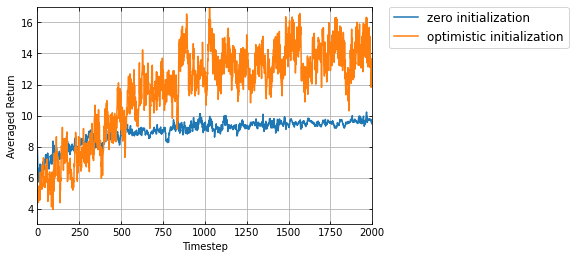

In [16]:
t_lim = 2000

# transform rewards to returns
return_t_list_zero       = np.zeros((t_lim,n_experiment))
return_t_list_optimistic = np.zeros((t_lim,n_experiment))
for t in reversed(range(t_lim)):
    if t==t_lim-1:
        geom = gamma ** np.array(range(n_timestep-t))
        return_t_list_zero[t]       = np.dot(geom, rewards_list_zero[t:,])
        return_t_list_optimistic[t] = np.dot(geom, rewards_list_optimistic[t:,])
    else:
        return_t_list_zero[t]       = rewards_list_zero[t]       + gamma * return_t_list_zero[t+1]
        return_t_list_optimistic[t] = rewards_list_optimistic[t] + gamma * return_t_list_optimistic[t+1]


# plot averaged return over timestep
plt.plot(np.mean(return_t_list_zero, axis=1), label='zero initialization')
plt.plot(np.mean(return_t_list_optimistic, axis=1), label='optimistic initialization')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.xlabel('Timestep')
plt.ylabel('Averaged Return')
plt.tick_params(top = True, right = True, direction = 'in')
plt.grid(which='both')
plt.ylim(3,17)
plt.xlim(0,t_lim)
plt.show()